In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
#environment
import gym
import os
import time
#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
from math import sqrt
import copy


logging_interval = 40
animate_interval = logging_interval * 5
logdir='./DDPG/'
VISUALIZE = False
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 12000
GAMMA=0.99
BATCH_SIZE = 128

# Environments to be tested on
env_name = 'InvertedDoublePendulum-v1'
#env_name = 'Pendulum-v0'
#env_name = 'HalfCheetah-v1' 
#env_name = 'MountainCarContinuous-v0'
#env_name = 'Humanoid-v1'
#env_name = 'Ant-v1'



# wrap gym to save videos
env = gym.make(env_name)
env1 = gym.make(env_name)
env2 = gym.make(env_name)
env3 = gym.make(env_name)

if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env1 = gym.wrappers.Monitor(env1, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env1._max_episodes_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")

# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

[2018-06-05 17:07:38,924] Making new env: InvertedDoublePendulum-v1
[2018-06-05 17:07:39,592] Making new env: InvertedDoublePendulum-v1
[2018-06-05 17:07:39,600] Making new env: InvertedDoublePendulum-v1
[2018-06-05 17:07:39,606] Making new env: InvertedDoublePendulum-v1


In [2]:
class NormalizeAction(gym.ActionWrapper):
    def action(self, action):
        action = (action + 1) / 2  
        action *= (self.action_space.high - self.action_space.low)
        action += self.action_space.low
        return action

    def reverse_action(self, action):
        action -= self.action_space.low
        action /= (self.action_space.high - self.action_space.low)
        a
        ction = action * 2 - 1
        return actions

def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)
        
class OrnsteinUhlenbeckProcess:
    def __init__(self, mu=np.zeros(act_dim), sigma=0.05, theta=.25, dimension=1e-2, x0=None,num_steps=12000):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dimension
        self.x0 = x0
        self.reset()

    def step(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [3]:
class AdaptiveParamNoiseSpec(object):
    def __init__(self, initial_stddev=0.1, desired_action_stddev=0.2, adaptation_coefficient=1.01):
        """
        Note that initial_stddev and current_stddev refer to std of parameter noise, 
        but desired_action_stddev refers to (as name notes) desired std in action space
        """
        self.initial_stddev = initial_stddev
        self.desired_action_stddev = desired_action_stddev
        self.adaptation_coefficient = adaptation_coefficient

        self.current_stddev = initial_stddev

    def adapt(self, distance):
        if distance > self.desired_action_stddev:
            # Decrease stddev.
            self.current_stddev /= self.adaptation_coefficient
        else:
            # Increase stddev.
            self.current_stddev *= self.adaptation_coefficient

    def get_stats(self):
        stats = {
            'param_noise_stddev': self.current_stddev,
        }
        return stats

    def __repr__(self):
        fmt = 'AdaptiveParamNoiseSpec(initial_stddev={}, desired_action_stddev={}, adaptation_coefficient={})'
        return fmt.format(self.initial_stddev, self.desired_action_stddev, self.adaptation_coefficient)

def ddpg_distance_metric(actions1, actions2):
    """
    Compute "distance" between actions taken by two policies at the same states
    Expects numpy arrays
    """
    diff = actions1-actions2
    mean_diff = np.mean(np.square(diff), axis=0)
    dist = sqrt(np.mean(mean_diff))
    return dist


def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
           target_param.data.copy_(param.data)

In [4]:
import random

class Replay(object):
    def __init__(self, maxlen = 60000):
        self.maxlen = maxlen
        #self.data = deque(maxlen = self.maxlen)
        self.data=[]
        self.position=0
#         self.initialize(init_length=1000, envir=env)
        
    def initialize(self,init_length=1000, envir=env):
        s = envir.reset()
        for i in range (init_length):
            #a = np.random.random(1)-np.random.random(1)
            a = env.action_space.sample()
            s1, r, done, _ = env.step(a)            
            self.add((s,a,r,s1,done))
                        
            if done:
                s=envir.reset()
            else: 
                s = s1  
              
    def add(self, ep):
        self.data.append(ep)
        self.position = (self.position + 1) % self.maxlen       
        #self.data[self.position] = tuple(ep)
        
    def sample(self, batch_size):     
        return random.sample(self.data, batch_size)


In [5]:
class critic(nn.Module):

    def __init__(self, state_size, action_size, output_size = 1):
        super(critic, self).__init__()

        self.state_dim = state_size
        self.action_dim = action_size
        h1_dim = 300
        h2_dim = 300
        self.fc1 = nn.Linear(self.state_dim, h1_dim)
        #self.bn1 = nn.BatchNorm1d(h1_dim)
        self.fc2 = nn.Linear(h1_dim + self.action_dim, h2_dim)
        self.fc3 = nn.Linear(h2_dim, output_size)

    def forward(self, state, action):
        #s1 = F.relu(self.bn1(self.fc1(state)))
        s1 = F.relu(self.fc1(state))
        x = torch.cat((s1,action), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class actor(nn.Module):

    def __init__(self, input_size, output_size):
        super(actor, self).__init__()

        self.state_dim = input_size
        self.action_dim = output_size
        h1_dim = 400
        h2_dim = 400
        self.fc1 = nn.Linear(self.state_dim, h1_dim)
        #self.bn1 = nn.BatchNorm1d(h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        #self.bn2 = nn.BatchNorm1d(h2_dim)
        self.fc3 = nn.Linear(h2_dim, self.action_dim)

    def forward(self, state):
        #x = F.relu(self.bn1(self.fc1(state)))
        #x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = F.tanh(self.fc3(x))
        return action

In [6]:
class DDPG:
    def __init__(self, obs_dim, act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = GAMMA, batch_size = BATCH_SIZE):
        
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_perturbed = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        if use_cuda:
            self.actor.cuda()
            self.actor_target.cuda()
            self.critic.cuda()
            self.critic_target.cuda()
            
        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = NUM_EPISODES)
    
    def action(self, s, noise, para):
        obs = torch.from_numpy(s).unsqueeze(0)
        inp = Variable(obs,requires_grad=False).type(FloatTensor)

        self.actor.eval()
        self.actor_perturbed.eval()

        if para is not None:
            a = self.actor_perturbed(inp).data[0].cpu().numpy() 
        else:
            a = self.actor(inp).data[0].cpu().numpy() 
        self.actor.train()

        if noise is not None:
            a = a + noise
        return a
    
    def perturb_actor_parameters(self, param_noise):
        """Apply parameter noise to actor model, for exploration"""
        hard_update(self.actor_perturbed, self.actor)
        params = self.actor_perturbed.state_dict()
        for name in params:
            if 'ln' in name: 
                pass 
            param = params[name]
            random = torch.randn(param.shape)
            if use_cuda:
                random = random.cuda()
            param += random * param_noise.current_stddev
            
    def train(self, training_data):
        batch_s,batch_a,batch_r,batch_s1,batch_done=zip(*training_data)
        s1 = Variable(FloatTensor(batch_s))
        a1 = Variable(FloatTensor(batch_a))
        r1 = Variable(FloatTensor(np.array(batch_r).reshape(-1,1)))
        s2 = Variable(FloatTensor(batch_s1))
        d  = Variable(FloatTensor(1.0*np.array(batch_done).reshape(-1,1)))
        
        a2 = self.actor_target(s2)
        # ---------------------- optimize critic ----------------------
        next_val = self.critic_target(s2, a2).detach()
        q_expected = r1 + self.gamma*next_val*(1.0-d)
        q_predicted = self.critic(s1, a1)
        
        # compute critic loss, and update the critic
        loss_critic = self.critic_loss(q_predicted, q_expected)
        self.optimizer_critic.zero_grad()
        loss_critic.backward()
        self.optimizer_critic.step()

        # ---------------------- optimize actor ----------------------
        pred_a1 = self.actor.forward(s1)
        loss_actor = -1*self.critic(s1, pred_a1)
        loss_actor = loss_actor.mean()
        
        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        self.optimizer_actor.step()

        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)
        

In [7]:
ddpg1 = DDPG(obs_dim = obs_dim, act_dim = act_dim)
ddpg2 = DDPG(obs_dim = obs_dim, act_dim = act_dim)
ddpg3 = DDPG(obs_dim = obs_dim, act_dim = act_dim)
memory = Replay(60000)
memory.initialize(init_length=150, envir=env)

In [8]:
#env = NormalizeAction(env) # remap action values for the environment
avg_val = 0


env1 = NormalizeAction(env1)
env2 = NormalizeAction(env2)
env3 = NormalizeAction(env3)

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_count = 0
total_rewards=[]
# set term_condition for early stopping according to environment being used
#term_condition = -150 # Pendulum
#term_condition = 500 # inverted Pendulum
term_condition = 8500 # half cheetah

param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.05,desired_action_stddev=0.3, adaptation_coefficient=1.05)

for itr in range(NUM_EPISODES):
    s1 = env1.reset() # get initial state
    s2 = env2.reset()
    s3 = env3.reset()
    total_reward = [0, 0, 0]
    step_counter = [0,0,0]
    
    noise_counter=0
    ddpg1.perturb_actor_parameters(param_noise)
    ddpg2.perturb_actor_parameters(param_noise)
    ddpg3.perturb_actor_parameters(param_noise)
    
    done1 = 0
    done2 = 0
    done3 = 0
    
    while True:
        
        if not done1:
            ddpg1.noise.reset()
            a1 = ddpg1.action(s1, ddpg1.noise.step(), param_noise)
            s1_1, r1, done1, _ = env1.step(a1)
            memory.add((s1,a1,r1,s1_1,done1))
            total_reward[0] += r1
            step_counter[0] += 1
            training_data1 = np.array(memory.sample(BATCH_SIZE))
            ddpg1.train(training_data1)
            noise_counter += 1
            s1 = s1_1
            
        if not done2:
            ddpg2.noise.reset()
            a2 = ddpg2.action(s2, ddpg2.noise.step(), param_noise)
            
            s1_2, r2, done2, _ = env2.step(a2)
            memory.add((s2,a2,r2,s1_2,done2))
            total_reward[1] += r2
            step_counter[1] += 1
            training_data2 = np.array(memory.sample(BATCH_SIZE))
            ddpg2.train(training_data2)
            noise_counter += 1
            s2 = s1_2
            
        if not done3:
            ddpg3.noise.reset()
            a3 = ddpg3.action(s3, ddpg3.noise.step(), param_noise)
            
            s1_3, r3, done3, _ = env3.step(a3)
            memory.add((s3,a3,r3,s1_3,done3))
            total_reward[2] += r3
            
            step_counter[2] += 1
            training_data3 = np.array(memory.sample(BATCH_SIZE))
            ddpg3.train(training_data3)
            noise_counter += 1
            s3 = s1_3
            
        if done1 and done2 and done3:
            break
            
            
    ddpgs = [ddpg1, ddpg2, ddpg3]
    total_rewards.append(total_reward)
    idx = np.array(total_reward).argmax()
    myddpg = ddpgs[idx]

    ddpg1 = copy.deepcopy(myddpg)
    ddpg2 = copy.deepcopy(myddpg)
    ddpg3 = copy.deepcopy(myddpg)

    

    if memory.position-noise_counter > 0:
        noise_data=memory.data[memory.position-noise_counter:memory.position]
    else:
        noise_data=memory.data[memory.position-noise_counter+60000:60000] \
        + memory.data[0:memory.position]
        
    
    noise_data=np.array(noise_data)
    noise_s, noise_a, _,_ , _= zip(*noise_data)
    
    perturbed_actions = noise_a
    unperturbed_actions = myddpg.action(np.array(noise_s), None, None)
    ddpg_dist = ddpg_distance_metric(perturbed_actions, unperturbed_actions)
    param_noise.adapt(ddpg_dist)
    
    
    if itr > 3 and avg_val > term_condition:
        break
    running_rewards_ddpg.append(total_reward[idx]) # return of this episode
    step_count = step_count + step_counter[idx]
    step_list_ddpg.append(step_count)

    avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val,itr))

    
    
    

Average value: 6.470684103886741 for episode: 0
Average value: 10.246246062187812 for episode: 1
Average value: 11.538914891818962 for episode: 2
Average value: 14.150490835713095 for episode: 3
Average value: 15.255906482657455 for episode: 4
Average value: 16.289279561479326 for episode: 5
Average value: 17.241180448703602 for episode: 6
Average value: 18.157566711147446 for episode: 7
Average value: 19.03196986848931 for episode: 8
Average value: 19.8552289013931 for episode: 9
Average value: 20.63076573150447 for episode: 10
Average value: 21.389390697303227 for episode: 11
Average value: 22.132410261200167 for episode: 12
Average value: 22.79934901405461 for episode: 13
Average value: 23.43459154480516 for episode: 14
Average value: 24.015866053953648 for episode: 15
Average value: 25.548162021990784 for episode: 16
Average value: 26.028153010972364 for episode: 17
Average value: 26.475227196486316 for episode: 18
Average value: 26.949262860508124 for episode: 19
Average value: 27

Average value: 41.85130555865134 for episode: 166
Average value: 41.50940395848892 for episode: 167
Average value: 42.584730054853104 for episode: 168
Average value: 41.79910676480238 for episode: 169
Average value: 42.91228489481242 for episode: 170
Average value: 42.51776578588742 for episode: 171
Average value: 42.14553911906521 for episode: 172
Average value: 42.75603258046233 for episode: 173
Average value: 43.29068317014371 for episode: 174
Average value: 43.81316264908197 for episode: 175
Average value: 43.42263393058392 for episode: 176
Average value: 43.030469170082554 for episode: 177
Average value: 42.221945882476184 for episode: 178
Average value: 41.87738561720959 for episode: 179
Average value: 43.429739633135455 for episode: 180
Average value: 43.518424190956196 for episode: 181
Average value: 43.08607862364598 for episode: 182
Average value: 42.27360124218826 for episode: 183
Average value: 41.91477346065814 for episode: 184
Average value: 41.163770302511416 for episode

Average value: 39.89961202323797 for episode: 332
Average value: 41.10297329257849 for episode: 333
Average value: 40.853650741857415 for episode: 334
Average value: 40.55989905422282 for episode: 335
Average value: 39.876505035410176 for episode: 336
Average value: 39.22842889293529 for episode: 337
Average value: 39.9929311378918 for episode: 338
Average value: 39.766826964362075 for episode: 339
Average value: 39.52764195873004 for episode: 340
Average value: 39.29647649619244 for episode: 341
Average value: 39.08476014500992 for episode: 342
Average value: 38.47436600464131 for episode: 343
Average value: 38.316116727340805 for episode: 344
Average value: 37.74726416302105 for episode: 345
Average value: 37.20205350447346 for episode: 346
Average value: 37.09066558249851 for episode: 347
Average value: 36.98424965265679 for episode: 348
Average value: 38.777851476302885 for episode: 349
Average value: 38.182285714821944 for episode: 350
Average value: 39.47834502284151 for episode:

Average value: 130.0814722969931 for episode: 496
Average value: 129.59344794123723 for episode: 497
Average value: 128.65752140453185 for episode: 498
Average value: 129.9707323902505 for episode: 499
Average value: 128.08428388969187 for episode: 500
Average value: 125.81406470524074 for episode: 501
Average value: 125.99847111743154 for episode: 502
Average value: 128.9466621672595 for episode: 503
Average value: 127.58639910781415 for episode: 504
Average value: 127.20473373129272 for episode: 505
Average value: 125.91399507222845 for episode: 506
Average value: 124.2488741984352 for episode: 507
Average value: 123.08453451170266 for episode: 508
Average value: 124.33975052466425 for episode: 509
Average value: 127.40344359337878 for episode: 510
Average value: 126.5628868163893 for episode: 511
Average value: 129.5020381380271 for episode: 512
Average value: 129.02046512223012 for episode: 513
Average value: 128.54710010225398 for episode: 514
Average value: 130.43578562962284 for

Average value: 163.06769435663804 for episode: 658
Average value: 161.37481419295094 for episode: 659
Average value: 165.81525673225374 for episode: 660
Average value: 163.53405981071447 for episode: 661
Average value: 166.80320798802484 for episode: 662
Average value: 166.3217964469142 for episode: 663
Average value: 170.51623746374017 for episode: 664
Average value: 168.01223635486363 for episode: 665
Average value: 165.62265194240445 for episode: 666
Average value: 163.35955318521962 for episode: 667
Average value: 161.2211087262275 for episode: 668
Average value: 164.30786232045227 for episode: 669
Average value: 161.1885499452392 for episode: 670
Average value: 161.92466577901618 for episode: 671
Average value: 164.95079137929568 for episode: 672
Average value: 164.55868290968857 for episode: 673
Average value: 165.61378565129726 for episode: 674
Average value: 163.33714065050646 for episode: 675
Average value: 163.89949604823516 for episode: 676
Average value: 164.98587653380415 

Average value: 216.88604160000187 for episode: 820
Average value: 218.5643964619944 for episode: 821
Average value: 216.8939874146728 for episode: 822
Average value: 213.44900814352604 for episode: 823
Average value: 218.93409391572902 for episode: 824
Average value: 220.93762908328566 for episode: 825
Average value: 219.60022694624777 for episode: 826
Average value: 217.39003502811994 for episode: 827
Average value: 228.43302074132163 for episode: 828
Average value: 243.53417598795565 for episode: 829
Average value: 244.82434214344886 for episode: 830
Average value: 244.659768172197 for episode: 831
Average value: 243.57554378809604 for episode: 832
Average value: 246.70558125609625 for episode: 833
Average value: 254.349854353855 for episode: 834
Average value: 256.48443981865887 for episode: 835
Average value: 249.19932430748543 for episode: 836
Average value: 252.5035569477024 for episode: 837
Average value: 257.54700756924274 for episode: 838
Average value: 256.7303757670222 for e

Average value: 362.72705076260934 for episode: 983
Average value: 358.472426108836 for episode: 984
Average value: 354.42422334253894 for episode: 985
Average value: 355.1961550061178 for episode: 986
Average value: 364.83349366985675 for episode: 987
Average value: 366.0590604002912 for episode: 988
Average value: 360.23877593728173 for episode: 989
Average value: 358.47938264457986 for episode: 990
Average value: 367.96027784735907 for episode: 991
Average value: 371.909634580283 for episode: 992
Average value: 376.0267234164284 for episode: 993
Average value: 373.8816121571874 for episode: 994
Average value: 377.44116856382163 for episode: 995
Average value: 389.2274479073261 for episode: 996
Average value: 387.3415056508181 for episode: 997
Average value: 386.4512563630455 for episode: 998
Average value: 399.3328304846342 for episode: 999
Average value: 399.3501449347314 for episode: 1000
Average value: 415.6000414195357 for episode: 1001
Average value: 411.0378662867 for episode: 

Average value: 448.2074668056254 for episode: 1143
Average value: 443.46436568627684 for episode: 1144
Average value: 438.48875652514863 for episode: 1145
Average value: 427.6815812162611 for episode: 1146
Average value: 422.46818587185396 for episode: 1147
Average value: 417.5531387487845 for episode: 1148
Average value: 413.36447057246244 for episode: 1149
Average value: 413.1273173241116 for episode: 1150
Average value: 405.90652507245125 for episode: 1151
Average value: 403.22147068267327 for episode: 1152
Average value: 396.97002419057526 for episode: 1153
Average value: 391.4980635731193 for episode: 1154
Average value: 382.0007691412865 for episode: 1155
Average value: 429.2986639922043 for episode: 1156
Average value: 419.8388921958591 for episode: 1157
Average value: 415.06318162409815 for episode: 1158
Average value: 420.38808318626684 for episode: 1159
Average value: 419.74185770625434 for episode: 1160
Average value: 418.22245848727545 for episode: 1161
Average value: 417.3

Average value: 597.3182503085891 for episode: 1303
Average value: 613.1489912316277 for episode: 1304
Average value: 622.6183240591511 for episode: 1305
Average value: 611.9625472929278 for episode: 1306
Average value: 608.3931498722818 for episode: 1307
Average value: 599.8594639546496 for episode: 1308
Average value: 599.6901468326182 for episode: 1309
Average value: 587.8761364160297 for episode: 1310
Average value: 625.1321906642252 for episode: 1311
Average value: 646.6141995882803 for episode: 1312
Average value: 636.6401660532838 for episode: 1313
Average value: 631.7908425167491 for episode: 1314
Average value: 638.4041788669905 for episode: 1315
Average value: 633.5161810208426 for episode: 1316
Average value: 625.1293140242494 for episode: 1317
Average value: 629.7781974703068 for episode: 1318
Average value: 622.5077383508251 for episode: 1319
Average value: 623.5546158314006 for episode: 1320
Average value: 635.7622830840422 for episode: 1321
Average value: 683.706516546657

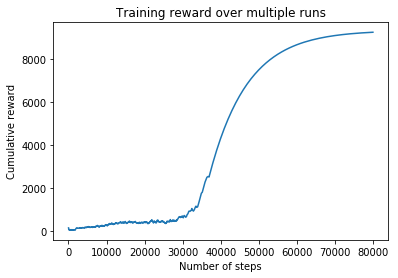

In [9]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

In [10]:
np.save('out.npy',out)
np.save('step_list_ddpg.npy',step_list_ddpg)

In [11]:
torch.save(myddpg.actor, 'actor.pt')
torch.save(myddpg.actor_perturbed, 'actor_perturbed.pt')
np.save('param_noise.npy',[param_noise.desired_action_stddev,
                           param_noise.adaptation_coefficient,
                           param_noise.current_stddev])

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type actor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
pnl = np.load('param_noise.npy')
myddpg.actor = torch.load('actor.pt')
myddpg.actor_perturbed = torch.load('actor_perturbed.pt')


In [13]:
env_name = 'InvertedDoublePendulum-v1'
env4 = gym.make(env_name)

# check whether the environment is discrete or continuous
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env4.observation_space.shape[0]
act_dim = env4.action_space.n if discrete else env.action_space.shape[0]
if discrete: print("This is a discrete action space, probably not the right algorithm to use")


logdir='./DDPG_final/'
logging_interval = 20
animate_interval = logging_interval * 5
VISUALIZE = True
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env4 = gym.wrappers.Monitor(env4, logdir, force=True, video_callable=lambda \
                               episode_id: episode_id%logging_interval==0)
env4._max_episodes_steps = MAX_PATH_LENGTH

env4 = NormalizeAction(env4) # remap action values for the environment

[2018-06-05 17:29:12,573] Making new env: InvertedDoublePendulum-v1


In [14]:
for i in range(2):
    SEED = 0   
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    s1 = env4.reset() # get initial state
    # env1.render()
    # time.sleep(0.05)
    count=0
    param_noise = AdaptiveParamNoiseSpec(pnl[2],pnl[0],pnl[1])
    while True: # for each episode, we loop each step in this episode
        myddpg.noise.reset()
        env4.render()
        time.sleep(0.05)
        # use actor to get action, add ddpg.noise.step() to action
        # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
        # to train mode after you're done getting the action
        a1 = myddpg.action(s1, myddpg.noise.step(), param_noise)
        s1_1, r1, done1, _ = env4.step(a1)
        s1 = s1_1
        if done1: break
        count+=1
print('Finish Visualization')

[2018-06-05 17:29:12,615] Starting new video recorder writing to /datasets/home/04/004/l5shi/276_MA_Noise/invDoublePendulum/DDPG_final/openaigym.video.0.293.video000000.mp4
[2018-06-05 17:29:12,617] GLFW error: 65544, desc: b'X11: RandR gamma ramp support seems broken'
[2018-06-05 17:29:12,658] GLFW error: 65544, desc: b'Linux: Failed to watch for joystick connections in /dev/input: No such file or directory'
[2018-06-05 17:29:12,658] GLFW error: 65544, desc: b'Linux: Failed to open joystick device directory /dev/input: No such file or directory'


Finish Visualization


In [15]:
count

999

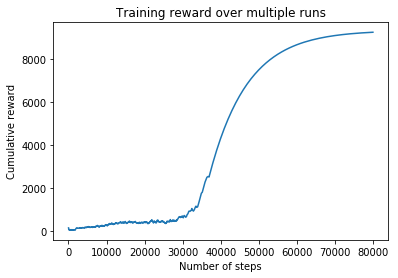

In [16]:
out=np.load('out.npy')
step_list_ddpg=np.load('step_list_ddpg.npy')

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()